#Imports

In [ ]:
import seaborn as sns
import math
import datetime
import numpy as np
import time
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models 
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import webbrowser
from tqdm import trange
from sklearn.metrics import roc_auc_score
import pandas as pd
import shutil

#Preprocessing

In [ ]:
csv_path = "~/root/meta_data.csv"   # Contains image folder names with lables.
zip_path = "~/root/600.zip"         # Compressed Data

In [ ]:
!unzip "~/root/600.zip" -d "/root/data"  

In [ ]:
class Image_Pipeline(Dataset):
    def __init__(self,path_dir,csv_file,transform=None):
        self.df = pd.read_csv(csv_file)
        self.path = path_dir
        self.transform = transform
        
    def __getitem__(self,index):
        image_name = self.df['image_name'].str.cat(['.jpg']*len(self.df)).values[index]
        image = Image.open(self.path+image_name).convert("RGB")
        label = torch.tensor(self.df.target.values[index],dtype = torch.long)
        
        if self.transform is not None:
            image = self.transform(image)
        return image,label

    def targets(self):
        label = torch.tensor(self.df.target.values,dtype = torch.float32)
        return label

    def __len__(self):
        return len(self.df)

In [ ]:
batch_size = 256
val_pct = 0.2
get_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_m = Image_Pipeline(path,"~/root/meta_data.csv",transform = get_transform)

In [ ]:
def visualize_image(data_obj,img_idx):
    img = data_obj.__getitem__(img_idx)[0].permute(2,1,0)
    plt.imshow(img)
    if data_obj.__getitem__(img_idx)[1].item() == 0.0:
        print("benign")
    else:
        print("malignant")

In [ ]:
train_set,val_set = random_split(dataset_m,[26500,6626])
traindata = DataLoader(train_set,batch_size=32,shuffle=True,num_workers = 2)
validation = DataLoader(val_set,batch_size=32,shuffle = True,num_workers = 2)
print("Training set size:{}\nValidation set size:{}".format((len(traindata)*batch_size)+(len(validation)*batch_size),len(dataset_m)))

In [ ]:
def inference(train_l,valid_l):
    tr = [i/len(traindata) for i in train_l]
    vl = [i/len(validation) for i in valid_l]
    plt.plot(tr)
    plt.plot(vl)
    plt.show()

#Modelling

In [ ]:
device=('cuda' if torch.cuda.is_available() else 'cpu')
model=models.resnet50(pretrained=True)

def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad=False
        
freeze_till_last(model)
incoming = model.fc.in_features

In [ ]:
def extended_seq(input_init,final_out):
    intermediate_inps = [input_init, input_init//2, input_init//4]
    layers = []
    for inf,outf in zip(intermediate_inps[:-1],intermediate_inps[1:]):
        layers.append(nn.Linear(in_features=inf, out_features = outf))
        layers.append(nn.BatchNorm1d(outf))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(intermediate_inps[-1],final_out))
    return nn.Sequential(*layers)

model.fc = extended_seq(incoming,final_out=1)      

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##Training Loop

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

def fit(model, traind, validation,epochs=4):
    train_loss = []
    valid_loss = []
    model.to(device) 
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(),lr=5e-3,momentum=0.95)#, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=0.5,eta_min=0.05)
    
    for epoch in trange(epochs):
        start = time.time()
        running_acc = 0
        running_train_loss = 0
        running_valid_loss = 0
        #traning the model
        model.train()
        for data,label in traind:
            data=data.to(device)
            label=label.to(device)            
            output = model(data)
            loss = loss_fn(output.view(1,len(data))[0],label.to(torch.float))
            running_train_loss += loss.item()*data.size(0)
            loss.backward()
            optimizer.step()
            model.zero_grad()
        #validation on the valid set
        with torch.no_grad():
            model.eval()
            for data_val,label_val in validation:
                data_val=data_val.to(device)
                label_val=label_val.to(device)            
                output = model(data_val)
                loss = loss_fn(output.view(1,len(data_val))[0],label_val.to(torch.float))
                running_valid_loss += loss.item()*data.size(0)
                try:
                    accuracy = roc_auc_score(label_val.to('cpu'),torch.sigmoid(output).view(-1).to('cpu'))
                    running_acc+=accuracy
                except:
                    pass
        train_loss.append(running_train_loss)
        valid_loss.append(running_valid_loss)
        torch.save(model.state_dict(), str('~/root/resn50n_'+str(epoch)+'.pt'))
        scheduler.step()
        print("\nTrain Loss:{:.4f} ".format(running_train_loss/len(train_set)),end='')
        print("Valid Loss:{:.4f} ".format(running_valid_loss/len(val_set)),end='')
        print("Valid Accuracy:{:.3f} ".format((running_acc/len(validation))*100),end='')
        print("Ellapsed time:{}".format(str(datetime.timedelta(seconds=time.time() - start))[:7]))        

    return train_loss,valid_loss

In [ ]:
arg = [model,traindata,validation,12]
train_l,valid_l = fit(*arg) 

  8%|▊         | 1/12 [20:21<3:43:53, 1221.22s/it]


Train Loss:0.0720 Valid Loss:0.1001 Valid Accuracy:83.574 Ellapsed time:0:20:21


 17%|█▋        | 2/12 [40:29<3:22:52, 1217.26s/it]


Train Loss:0.0711 Valid Loss:0.1005 Valid Accuracy:86.105 Ellapsed time:0:20:08


 25%|██▌       | 3/12 [1:00:26<3:01:41, 1211.23s/it]


Train Loss:0.0691 Valid Loss:0.0873 Valid Accuracy:85.931 Ellapsed time:0:19:57


 33%|███▎      | 4/12 [1:20:30<2:41:12, 1209.06s/it]


Train Loss:0.0685 Valid Loss:0.0814 Valid Accuracy:83.735 Ellapsed time:0:20:03


 42%|████▏     | 5/12 [1:40:45<2:21:16, 1211.00s/it]


Train Loss:0.0689 Valid Loss:0.0829 Valid Accuracy:85.050 Ellapsed time:0:20:15


 50%|█████     | 6/12 [2:01:05<2:01:22, 1213.69s/it]


Train Loss:0.0666 Valid Loss:0.0796 Valid Accuracy:85.650 Ellapsed time:0:20:19


 58%|█████▊    | 7/12 [2:20:51<1:40:26, 1205.31s/it]


Train Loss:0.0674 Valid Loss:0.0885 Valid Accuracy:86.243 Ellapsed time:0:19:45


 67%|██████▋   | 8/12 [2:41:02<1:20:27, 1206.83s/it]


Train Loss:0.0653 Valid Loss:0.0997 Valid Accuracy:86.902 Ellapsed time:0:20:10


 75%|███████▌  | 9/12 [3:01:23<1:00:33, 1211.25s/it]


Train Loss:0.0654 Valid Loss:0.0852 Valid Accuracy:87.968 Ellapsed time:0:20:21


 83%|████████▎ | 10/12 [3:21:43<40:27, 1213.86s/it] 


Train Loss:0.0639 Valid Loss:0.0907 Valid Accuracy:84.224 Ellapsed time:0:20:19


 92%|█████████▏| 11/12 [3:42:04<20:16, 1216.07s/it]


Train Loss:0.0650 Valid Loss:0.0727 Valid Accuracy:87.819 Ellapsed time:0:20:21


100%|██████████| 12/12 [4:02:25<00:00, 1212.13s/it]


Train Loss:0.0623 Valid Loss:0.0801 Valid Accuracy:88.817 Ellapsed time:0:20:20


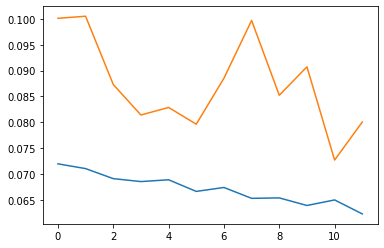

In [ ]:
inference(train_l,valid_l)

**Takeaway:**<br>
Stop training at epoch 10 as loss is optimal and further training may result in overfitting.<br>

# Model Performance on Test Set

In [ ]:
path_test = "~/root/test/"
path_test_csv = "~/root/test.csv"
model_path = "~/root/resn_50n_10.pt"

In [ ]:
data_frame = pd.read_csv("~/root/sample_submission.csv")
data_frame.head(3)

In [ ]:
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

In [ ]:
get_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
results = []
count = 0
with torch.no_grad():
    model.eval()  
    for file in data_frame.image_name:
        image = Image.open(path_test + file + ".jpg")
        image_t = get_transform(image)
        output = model(image_t.view(-1,3,224,224))
        results.append(round(torch.sigmoid(output).item(),4))
        count+=1
        if count%1000 == 0:
            print("ok")

In [ ]:
rows = list(data_frame.image_name)

In [ ]:
final=[]
for x,y in zip(rows,results):
    final.append([x,y])
data_submit = pd.DataFrame(ultimate,columns=("image_name","target"))
data_submit.to_csv("submission2res.csv",index=False)

**Results:**<br>
Achieved an accuracy of 0.8379 and 0.8347 on Public and
Private test sets.<br>
